# The config file

We specify the grid file, output rate and numerical step size.

In [1]:
yaml_file = "ladim.yaml"
yaml_text = """
time_control:
    # Start and stop of simulation
    start_time: 2015-10-08 01:00:00
    stop_time:  2015-10-08 23:00:00
    reference_time: 2015-10-08 01:00:00

files:
    grid_file             : ../../data/stromdata/norfjords_160m_his.nc4_2015100801-2015100900
    input_file            : ../../data/stromdata/norfjords_160m_his.nc4_2015100801-2015100900
    particle_release_file : station.rls
    output_file           : station.nc

state:
    # pid, X, Y, Z are mandatory and should not be given
    # Ingen, kan bruke [] eller kutte linjen
    ibm_variables: []

particle_release:
    variables: [release_time, X, Y, Z]
    # Converters (if not float)
    release_time: time
    particle_variables: [release_time]

gridforce:
    module: ladim.gridforce.ROMS

output_variables:
    # Output period, format [value, unit], unit = s, m, h, or d
    outper: [1, h]
    # Variable names
    particle: [release_time]
    instance: [pid, X, Y, Z]
    # NetCDF arguments
    release_time:
        ncformat: f8
        long_name: particle release time
        units: seconds since reference_time
    # Få til template over
    pid: {ncformat: i4, long_name: particle identifier}
    X: {ncformat: f4, long_name: particle X-coordinate}
    Y: {ncformat: f4, long_name: particle Y-coordinate}
    Z:
        ncformat: f4
        long_name: particle depth
        standard_name: depth_below_surface
        units: m
        positive: down


numerics:
    # Model time step, [value, unit]
    dt: [5, m]
    # Advection method: options =
    #        EF = Euler-Forward,
    #        RK2, RK4 = Runge-Kutta 2nd or 4th order
    advection: RK4
    # Horizontal diffusion coefficient [m2.s-1]
    #         zero = no diffusion
    diffusion: 0.15
"""

with open(yaml_file, 'w', encoding='utf-8') as f:
    f.write(yaml_text)

# Grid data

In [2]:
import netCDF4

grid_file = '../../data/stromdata/norfjords_160m_his.nc4_2015100801-2015100900'
grid = netCDF4.Dataset(grid_file)

lon_rho = grid.variables['lon_rho'][:, :]
lat_rho = grid.variables['lat_rho'][:, :]

lat_rho.shape

(961, 1241)

In [3]:
import numpy as np

# Convert to corner coordinates
def corners(x_center, y_center):
    rows, cols = x_center.shape

    x = np.zeros((rows + 1, cols + 1))
    y = np.zeros((rows + 1, cols + 1))
    
    # Internal edge points in rows
    x1 = 0.5 * (x_center[:-1, :] + x_center[1:, :])
    y1 = 0.5 * (y_center[:-1, :] + y_center[1:, :])

    # Internal edge points in cols
    x2 = 0.5 * (x_center[:, :-1] + x_center[:, 1:])
    y2 = 0.5 * (y_center[:, :-1] + y_center[:, 1:])

    # Internal corner points
    x[1:-1, 1:-1] = 0.5 * (x1[:, :-1] + x1[:, 1:])
    y[1:-1, 1:-1] = 0.5 * (y1[:, :-1] + y1[:, 1:])

    # Boundary points in rows
    x[0, 1:-1] = x2[0, :]
    y[0, 1:-1] = y2[0, :]
    x[-1, 1:-1] = x2[-1, :]
    y[-1, 1:-1] = y2[-1, :]

    # Boundary points in cols
    x[1:-1, 0] = x1[:, 0]
    y[1:-1, 0] = y1[:, 0]
    x[1:-1, -1] = x1[:, -1]
    y[1:-1, -1] = y1[:, -1]

    # Corner points
    x[0, 0] = x_center[0, 0]
    x[0, -1] = x_center[0, -1]
    x[-1, 0] = x_center[-1, 0]
    x[-1, -1] = x_center[-1, -1]
    y[0, 0] = y_center[0, 0]
    y[0, -1] = y_center[0, -1]
    y[-1, 0] = y_center[-1, 0]
    y[-1, -1] = y_center[-1, -1]
    
    return x, y

lon_corner, lat_corner = corners(lon_rho, lat_rho)
lon_corner.shape, lat_corner.shape

((962, 1242), (962, 1242))

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm
cmap = matplotlib.cm.jet
cmap.set_bad('#eeeeee')

mask = grid.variables['mask_rho'][:,:] == 0

def meshplot(gridded_data=None):
    if gridded_data is None:
        gridded_data = np.zeros(mask.shape)
    masked_data = np.ma.masked_array(gridded_data, mask=mask)
    fig = plt.figure()
    quad = plt.pcolormesh(lon_corner, lat_corner, masked_data, cmap=cmap)
    return fig, quad

depth = grid.variables['h'][:, :]
meshplot(depth)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.collections.QuadMesh at 0x1427971c668>)

# Release location

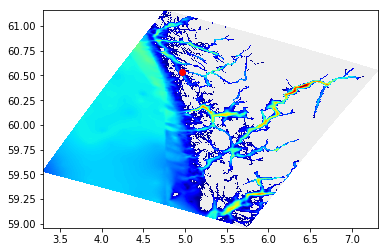

In [5]:
storoksen_lon = 4 + 58.017/60
storoksen_lat = 60 + 31.939/60

meshplot(depth)
plt.plot(storoksen_lon, storoksen_lat, 'ro')

# Release file

In [6]:
from ladim.sample import bilin_inv

def lonlat2etaxi(lon, lat):
    return bilin_inv(lon, lat, lon_rho, lat_rho, tol=1e-14, maxiter=7)

storoksen_eta, storoksen_xi = lonlat2etaxi(storoksen_lon, storoksen_lat)
storoksen_eta, storoksen_xi

(714.0000891821933, 875.0039288828794)

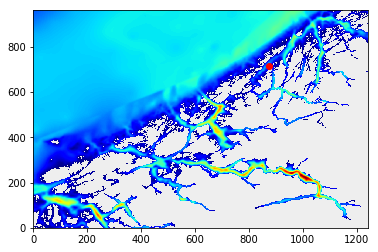

In [7]:
masked_depth = np.ma.masked_array(depth, mask=mask)

plt.figure()
plt.pcolormesh(masked_depth, cmap=cmap)
plt.plot(storoksen_xi, storoksen_eta, 'ro')

In [8]:
import numpy as np

release_file = 'station.rls'

num_particles = 1000

with open(release_file, 'w', encoding='utf-8') as f:
    for i in range(num_particles):
        particle_xi = storoksen_xi + 2*np.random.randn()
        particle_eta = storoksen_eta + 2*np.random.randn()
        f.write(f'2015-10-08T01 {particle_xi} {particle_eta} 0\n')

f'2015-10-08T01 {storoksen_xi} {storoksen_eta} 0'

'2015-10-08T01 875.0039288828794 714.0000891821933 0'

# Ladim simulation

In [9]:
import ladim
import logging
ladim.main(loglevel=logging.WARNING)

t =  0
start, end =  0 1000
t =  1
start, end =  1000 2000
t =  2
start, end =  2000 3000
t =  3
start, end =  3000 4000
t =  4
start, end =  4000 5000
t =  5
start, end =  5000 6000
t =  6
start, end =  6000 7000
t =  7
start, end =  7000 8000
t =  8
start, end =  8000 9000
t =  9
start, end =  9000 10000
t =  10
start, end =  10000 11000
t =  11
start, end =  11000 12000
t =  12
start, end =  12000 13000
t =  13
start, end =  13000 14000
t =  14
start, end =  14000 15000
t =  15
start, end =  15000 16000
t =  16
start, end =  16000 17000
t =  17
start, end =  17000 18000
t =  18
start, end =  18000 19000
t =  19
start, end =  19000 20000
t =  20
start, end =  20000 21000
t =  21
start, end =  21000 22000
t =  22
start, end =  22000 23000


# Plot initial particle location

Get grid coordinates of particles:

In [10]:
import scipy.sparse

def get_ladim_data(particle_file):
    with netCDF4.Dataset(particle_file) as dataset:
        indptr = np.concatenate(([0], dataset.variables['particle_count'][:].cumsum()))
        indices = dataset.variables['pid'][:]
        data = np.arange(1, len(indices)+1)
        xi = dataset.variables['X'][:]
        eta = dataset.variables['Y'][:]
        z = dataset.variables['Z'][:]
        times = dataset.variables['time'][:]
    coords = np.stack((xi, eta, z))
    matrix = scipy.sparse.csr_matrix((data, indices, indptr))
    return coords, matrix, times

all_coords, all_coord_idx, times = get_ladim_data('station.nc')
num_particles = all_coord_idx.shape[1]

def get_particle_coords(timesteps, particle_id):
    coord_idx = all_coord_idx[timesteps, particle_id].toarray().ravel() - 1
    return all_coords[:, coord_idx]

get_particle_coords(0, range(5))

array([[876.0583 , 872.9862 , 873.6266 , 872.80524, 878.20404],
       [713.8183 , 714.72595, 715.1784 , 717.0576 , 715.81226],
       [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ]],
      dtype=float32)

Convert to longitude and latitude:

In [11]:
from scipy.interpolate import RegularGridInterpolator

eta_range = np.arange(0, lon_rho.shape[0])
xi_range = np.arange(0, lon_rho.shape[1])

etaxi2lon = RegularGridInterpolator((eta_range, xi_range), lon_rho[:,:], method='linear')
etaxi2lat = RegularGridInterpolator((eta_range, xi_range), lat_rho[:,:], method='linear')

def get_particle_lonlat(timesteps, particle_id):
    coords = get_particle_coords(timesteps, particle_id)
    lon = etaxi2lon(coords[[1, 0], :].T)
    lat = etaxi2lat(coords[[1, 0], :].T)
    return lon, lat

get_particle_lonlat(0, range(5))

(array([4.96873173, 4.9625397 , 4.96213092, 4.95614118, 4.96609654]),
 array([60.53358205, 60.5301244 , 60.531235  , 60.53130457, 60.53759391]))

Plot initial particle location:

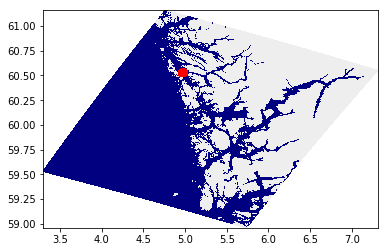

In [12]:
lon, lat = get_particle_lonlat(0, range(num_particles))

meshplot()
plt.plot(lon, lat, 'ro')

# Plot moving particles

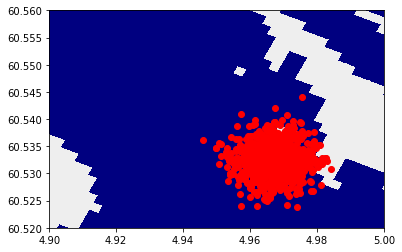

In [13]:
fig, _ = meshplot()
dots = plt.plot(lon, lat, 'ro')[0]
plt.xlim([4.9, 5.0])
plt.ylim([60.52, 60.56])

def plot_dots(timestep):
    lon, lat = get_particle_lonlat(timestep, range(num_particles))
    dots.set_data(lon, lat)
    return dots

plot_dots(0)

In [14]:
import matplotlib.animation as animation
import matplotlib
from IPython.display import HTML

anim = animation.FuncAnimation(fig, plot_dots, frames=len(times), interval=500, repeat=False)

HTML(anim.to_html5_video())

# Plot areal concentration

Define grid for box-counting

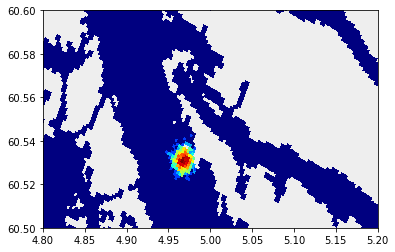

In [26]:
xi_edges = range(lon_rho.shape[1] + 1)
eta_edges = range(lon_rho.shape[0] + 1)
coords = get_particle_coords(0, range(num_particles))
count, _, _ = np.histogram2d(coords[1, :], coords[0, :], [eta_edges, xi_edges])
fig, quad = meshplot(np.log(count+1))
plt.xlim([4.8, 5.2])
plt.ylim([60.5, 60.6])


def plot_concentration(timestep):
    coords = get_particle_coords(timestep, range(num_particles))
    count, _, _ = np.histogram2d(coords[1, :], coords[0, :], [eta_edges, xi_edges])
    count_masked = np.ma.masked_array(np.log(count+1), mask=mask)
    quad.set_array(count_masked.ravel())
    return quad

plot_concentration(0)

In [27]:
anim = animation.FuncAnimation(fig, plot_concentration, frames=len(times), interval=500, repeat=False)
HTML(anim.to_html5_video())